# Causal Impact in JAX

We illustrate the causal impact library applied to the simple example
which is used in the original <a href="https://google.github.io/CausalImpact/CausalImpact.html">CausalImpact R package</a>
(which is built upon the R package <a href="https://cran.r-project.org/web/packages/bsts/bsts.pdf"> bsts </a> for Bayesian structural time series models).

Note that there are several other packages that implement the causal impact algorithm with python:
* The package <a href="https://github.com/WillianFuks/tfcausalimpact">tfcausalimpact</a> is built upon the <a href="https://www.tensorflow.org/probability/api_docs/python/tfp/sts">tfp.sts module</a>.
* The package <a href="https://pypi.org/project/pycausalimpact/">pycausalimpact</a> is built upon <a href="https://github.com/statsmodels/statsmodels">statsmodels</a>.
* The package <a href="https://github.com/jamalsenouci/causalimpact">causalimpact</a> is build on  <a href="https://www.pymc.io/welcome.html">pymc</a>.



In [1]:
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt
from sts_jax.causal_impact.causal_impact import causal_impact

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


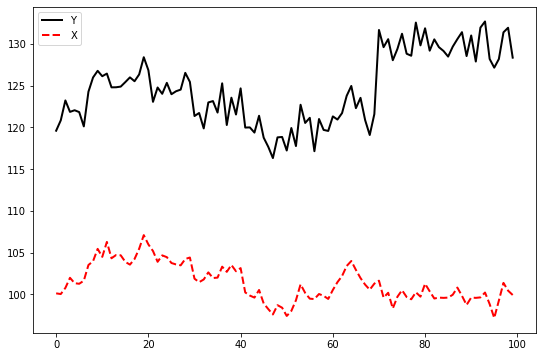

In [2]:
num_timesteps = 100

def auto_regress(x, key):
    x_new = 0.95 * x + jr.normal(key)
    return x_new, x

key = jr.PRNGKey(16)
x0 = jr.normal(key)
keys = jr.split(key, num_timesteps)
_, x =  lax.scan(auto_regress, x0, keys)
x = x + 100

y = 1.2*x + jr.normal(key, shape=(num_timesteps,))
y = y.at[70:].set(y[70:]+10)

plt.figure(figsize=(9, 6))
plt.plot(y, label='Y', color='black', lw=2)
plt.plot(x, linestyle='dashed', color='red', lw=2, label='X')
plt.legend()

In [3]:

obs_time_series = jnp.expand_dims(y, 1)
covariates = jnp.expand_dims(x, 1)
intervention_timepoint = 70

impact = causal_impact(obs_time_series, intervention_timepoint, 'Gaussian', covariates,
                       sts_model=None, confidence_level=0.95, key=jr.PRNGKey(0), num_samples=200)

Running window adaptation


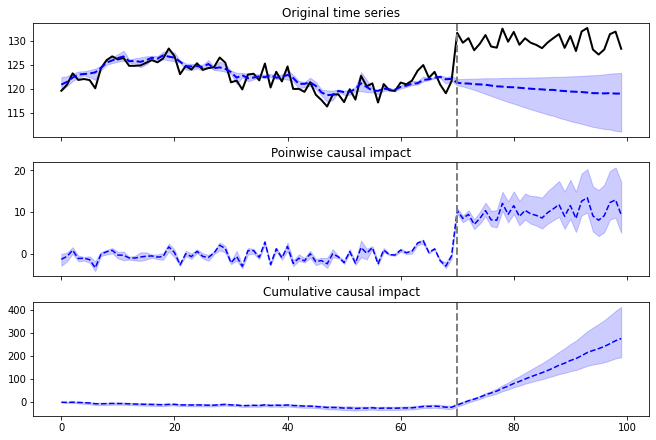

In [5]:
impact.plot()
plt.savefig('causal-impact-3panel.pdf')
plt.show()



In [6]:
impact.print_summary()

Posterior inference of the causal impact:

                               Average            Cumulative     
Actual                          129.93             3897.88       

Prediction (s.d.)           120.01 (2.04)      3600.42 (61.31)   
95% CI                     [114.82, 123.07]   [3444.72, 3692.09] 

Absolute effect (s.d.)       9.92 (2.04)        297.45 (61.31)   
95% CI                      [6.86, 15.11]      [205.78, 453.16]  

Relative effect (s.d.)      8.29% (1.89%)       8.29% (1.89%)    
95% CI                     [5.57%, 13.16%]     [5.57%, 13.16%]   

Posterior tail-area probability p: 0.0050
Posterior prob of a causal effect: 99.50%

